In [21]:
''' Install necessary packages '''

%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install pyarrow        ### pyarrow and fastparquet are new to me: these are necessary for loading parquet file data
%pip install fastparquet
%pip install xgboost



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import csv
import our_functions
import importlib
importlib.reload(our_functions)
from xgboost import XGBRegressor



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note

In [2]:
''' Load the data '''

datapath = '../../IceCube_Training_Data/'                                                   ### Adjust your path to match where you are keeping the parquet files
batch_list = [pd.read_parquet(datapath+'batch_'+str(i)+'.parquet') for i in range(1,6)]     ### I renamed the parquet files so I could easily loop over them and aggregate the events
rawdata = pd.concat(batch_list)
events = rawdata.index.drop_duplicates()
rawdata_meta = pd.read_parquet('../../train_meta.parquet')
rawdata_meta = rawdata_meta.loc[rawdata_meta['event_id'].isin(events)]
merged_data = pd.merge(rawdata, rawdata_meta, on='event_id')

aggregated_data = merged_data.groupby('event_id').agg({
    'zenith': 'mean',
    'azimuth': 'mean',
    'sensor_id': 'count',   # number of sensors triggered
    'time': ['min', 'max'],  # earliest and latest trigger time
    'charge': ['min', 'max', 'mean']  # minimum, maximum, and average charge
})

aggregated_data.columns = ['_'.join(col).strip() for col in aggregated_data.columns.values] # Flatten the column names


In [11]:
X = aggregated_data.drop(['zenith_mean', 'azimuth_mean'], axis=1)
y = aggregated_data[['zenith_mean', 'azimuth_mean']]

# Split the data into training and testing (validation) sets.  We choose 80% of data to be for training,
# the other 20% for validation testing.  We choose a random state seed value to randomize yet track how
# the data will be split.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=117)


# We test multiple estimator values of the random forest and plot the score
predictions = []
estimator_number = np.concatenate([np.array([1,10]),np.arange(100,1100,100)])  #Specify tree values to test

for i in estimator_number:

    print('Starting model '+str(i)+' of '+str(len(estimator_number)))

    xgb = XGBRegressor(n_estimators=i, random_state=117, verbose=True) #Create a forest of size i
    mor = MultiOutputRegressor(xgb)  #Create the multi-output regressor with the forest

    mor.fit(X_train, y_train)   #Train the model
    predictions.append(mor.predict(X_test))     #Predict the targets for the validation set


Starting model 1 of 12
[07:18:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[07:18:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Starting model 10 of 12
[07:18:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[07:18:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Starting model 100 of 12
[07:18:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[07:18:54] WARNING: /Users/r

In [22]:
scores = []

for model in predictions:
    model_scores = []
    print('Scoring new model.')
    for event in range(len(model)):
        model_scores.append(angular_dist_score( y_test['zenith_mean'].iloc[event], y_test['azimuth_mean'].iloc[event], model[event][0],model[event][1]))
    scores.append(model_scores)

Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.
Scoring new model.


Text(0.5, 1.0, 'XGBoost Scores')

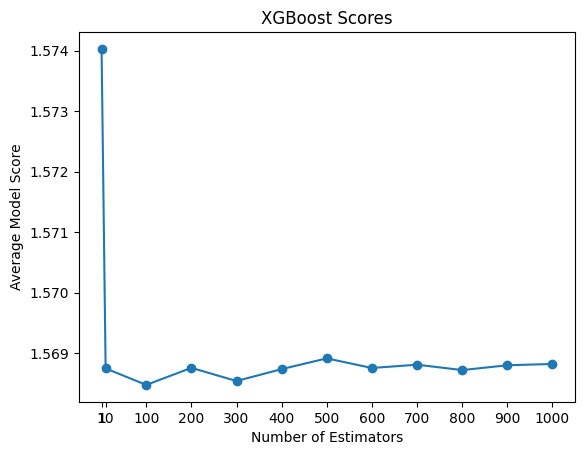

In [23]:
plt.plot(estimator_number,np.mean(np.array(scores), axis=1),marker='o')
plt.xticks([int(i) for i in estimator_number])
plt.xlabel('Number of Estimators')
plt.ylabel('Average Model Score')
plt.title('XGBoost Scores')